### Question 5: Implementation Gap

**Compare yield-space P&L to bond-space returns.**

This question confronts the gap between academic factor analysis and implementable trades.

a) **Design a roll schedule.** Using the bond panel (`treasury_panel_pca.xlsx`), you need to select actual bonds to proxy 2Y, 5Y, and 10Y maturities. Decide on:
   - **Roll frequency:** monthly or quarterly?
   - **Selection criteria:** closest TTM to target? Prefer on-the-run (low `age_days`)?
   
   Document your choices and rationale. There is no single correct answer—tradeoffs exist between tracking error, transaction costs, and liquidity.

b) **Construct the butterfly using actual bonds.** At each roll date:
   - Select the bond closest to each target maturity (2Y, 5Y, 10Y)
   - Apply your PCA-neutral weights, scaled by duration
   - Hold these bonds until the next roll date
   
   Compute daily bond returns between roll dates (price changes plus accrued interest changes).

c) **Compare yield-space vs bond-space P&L.** Compute the correlation and R² between:
   - Yield-space butterfly changes (from Question 3)
   - Bond-space portfolio returns
   
   Plot both series on the same chart.

d) **Analyze the sources of discrepancy:**

   - **Yield changes**: At each timestep, the indivudal bond's yield change will be different than the fixed maturity yield change. This is due to different maturities as well as factors idiosyncratic to the bond itself. How correlated are GSW yield changes with held bond yield changes? Show the relationship with a plot.
     
   - **First-order approxiation**: We can model bond returns from yields via first order approximation via duration. How correlated are our approximated returns to the actual bond returns? Show the relationship with a plot.

e) **Discuss:** Is the yield-space backtest a reliable guide to actual trading performance? What adjustments would you make for a production implementation?

## Data Loading

    Initial data loading, exploration, and notebook scaffolding for this question were developed with the assistance of Claude Code (Opus 4.6, Anthropic)

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [30]:
gsw = pd.read_excel("data/gsw_yields.xlsx", index_col=0, parse_dates=True)
maturities = [2, 5, 10]
yields = gsw[maturities].dropna()
yields.columns = ["2Y", "5Y", "10Y"]
yields = yields.loc["2015":]
yields_diff = yields.diff(periods=1).dropna()

weights = np.ndarray([])
# PCA weights from Question 2
%store -r weights
print(f"Butterfly weights: {weights}")

panel = pd.read_excel(
    "data/treasury_panel_pca.xlsx", parse_dates=["caldt", "issue_date", "maturity_date"]
)
print(f"Panel shape: {panel.shape}")
print(f"Date range: {panel['caldt'].min().date()} to {panel['caldt'].max().date()}")
print(f"Unique dates: {panel['caldt'].nunique()}, Unique bonds: {panel['kytreasno'].nunique()}")

Butterfly weights: [ 0.49469041 -1.          0.56594124]
Panel shape: (204868, 14)
Date range: 2022-01-03 to 2025-12-31
Unique dates: 999, Unique bonds: 416


In [31]:
panel.head(10)

,caldt,kytreasno,cusip,type,issue_date,maturity_date,ttm,age_days,coupon,ytm,price,accrued_int,dirty_price,duration
0,2022-01-03,207470,912828Z2,note,2020-01-15,2023-01-15,1.032170,719,1.500,0.004412,101.089844,0.701087,101.790931,1.021804
1,2022-01-03,206940,912828P3,note,2016-01-31,2023-01-31,1.075975,2164,1.750,0.004530,101.390625,0.741848,102.132473,1.063840
2,2022-01-03,207174,9128283U,note,2018-01-31,2023-01-31,1.075975,1433,2.375,0.004478,102.066406,1.006793,103.073200,1.059402
3,2022-01-03,207663,91282CBG,note,2021-01-31,2023-01-31,1.075975,337,0.125,0.004456,99.656250,0.052989,99.709239,1.075771
4,2022-01-03,204081,912810EP,bond,1993-02-15,2023-02-15,1.117043,10549,7.125,0.004844,107.386719,2.729959,110.116678,1.069214
5,2022-01-03,206591,912828UN,note,2013-02-15,2023-02-15,1.117043,3244,2.000,0.004690,101.703125,0.766304,102.469429,1.103149
6,2022-01-03,207489,912828Z8,note,2020-02-15,2023-02-15,1.117043,688,1.375,0.004585,101.019531,0.526834,101.546365,1.107638
7,2022-01-03,206948,912828P7,note,2016-02-29,2023-02-28,1.152635,2135,1.500,0.004683,101.187500,0.517956,101.705456,1.142410
8,2022-01-03,207184,9128284A,note,2018-02-28,2023-02-28,1.152635,1405,2.625,0.004858,102.460938,0.906423,103.367360,1.134460
9,2022-01-03,207674,91282CBN,note,2021-02-28,2023-02-28,1.152635,309,0.125,0.004791,99.593750,0.043163,99.636913,1.152488


In [32]:
panel.describe()

,caldt,kytreasno,issue_date,maturity_date,ttm,age_days,coupon,ytm,price,accrued_int,dirty_price,duration
count,204868,204868.000000,204868,204868,204868.000000,204868.000000,204868.000000,204868.000000,204868.000000,204868.000000,204868.000000,204868.000000
mean,2023-12-29 22:13:16.376203,207468.793125,2019-10-10 02:43:39.677060,2027-09-11 03:17:50.995958,3.699416,1541.812230,2.675650,0.038907,96.504589,0.655434,97.160023,3.456354
min,2022-01-03 00:00:00,204081.000000,1993-02-15 00:00:00,2023-01-15 00:00:00,1.002053,-9.000000,0.125000,0.004195,75.003906,0.000000,75.114300,0.952123
25%,2023-01-03 00:00:00,207361.000000,2019-05-15 00:00:00,2025-12-15 00:00:00,1.963039,359.000000,1.250000,0.036072,93.101562,0.178867,93.463083,1.919709
50%,2023-12-28 00:00:00,207730.000000,2021-06-15 00:00:00,2027-05-31 00:00:00,3.230664,871.000000,2.625000,0.040265,96.890625,0.480978,97.488731,3.114782
75%,2024-12-27 00:00:00,207989.000000,2022-12-31 00:00:00,2029-02-15 00:00:00,4.936345,1622.000000,4.000000,0.043832,99.972656,0.969613,100.800722,4.610975
max,2025-12-31 00:00:00,208504.000000,2025-12-31 00:00:00,2037-05-15 00:00:00,12.000000,10776.000000,7.625000,0.055252,136.929688,3.791780,137.775682,9.458658
std,NaN,997.015130,NaN,NaN,2.100097,2265.353203,1.633997,0.008153,5.932123,0.602986,6.262930,1.822890


In [33]:
target_mats = [2, 5, 10]
tolerance = 0.5

sample_date = panel["caldt"].iloc[len(panel) // 2]
day = panel[panel["caldt"] == sample_date]

print(f"Sample date: {sample_date.date()} ({len(day)} bonds)")
print()
for t in target_mats:
    nearby = day[(day["ttm"] >= t - tolerance) & (day["ttm"] <= t + tolerance)]
    print(f"""--- {t}Y bucket (TTM {t - tolerance:.1f} to {t + tolerance:.1f}) ---
    {len(nearby)} bonds, age_days range: {nearby["age_days"].min():.0f} to {
        nearby["age_days"].max():.0f}"
    TTM range: {nearby["ttm"].min():.2f} to {nearby["ttm"].max():.2f}")

        {
        nearby[["kytreasno", "cusip", "ttm", "age_days", "duration", "ytm", "type"]]
        .sort_values("ttm")
        .head()
        .to_string(index=False)
    }
    
    """)

Sample date: 2023-12-28 (207 bonds)

--- 2Y bucket (TTM 1.5 to 2.5) ---
    49 bonds, age_days range: -3 to 10362"
    TTM range: 1.51 to 2.46")

         kytreasno    cusip      ttm  age_days  duration      ytm type
    207224 912828XZ 1.505818      2007  1.465811 0.045006 note
    207560 912828ZW 1.505818      1276  1.502927 0.044973 note
    208073 91282CHL 1.505818       181  1.440285 0.044853 note
    207915 91282CEY 1.546886       531  1.503403 0.044823 note
    207232 912828Y7 1.590691      1976  1.549001 0.044602 note

    
--- 5Y bucket (TTM 4.5 to 5.5) ---
    26 bonds, age_days range: -3 to 9266"
    TTM range: 4.51 to 5.42")

         kytreasno    cusip      ttm  age_days  duration      ytm type
    207732 91282CCH 4.506502       911  4.360718 0.038853 note
    208075 91282CHK 4.506502       181  4.091957 0.038813 note
    207745 91282CCR 4.591376       880  4.473899 0.038804 note
    208087 91282CHQ 4.591376       150  4.166386 0.038685 note
    204092 912810FE 4.632444   

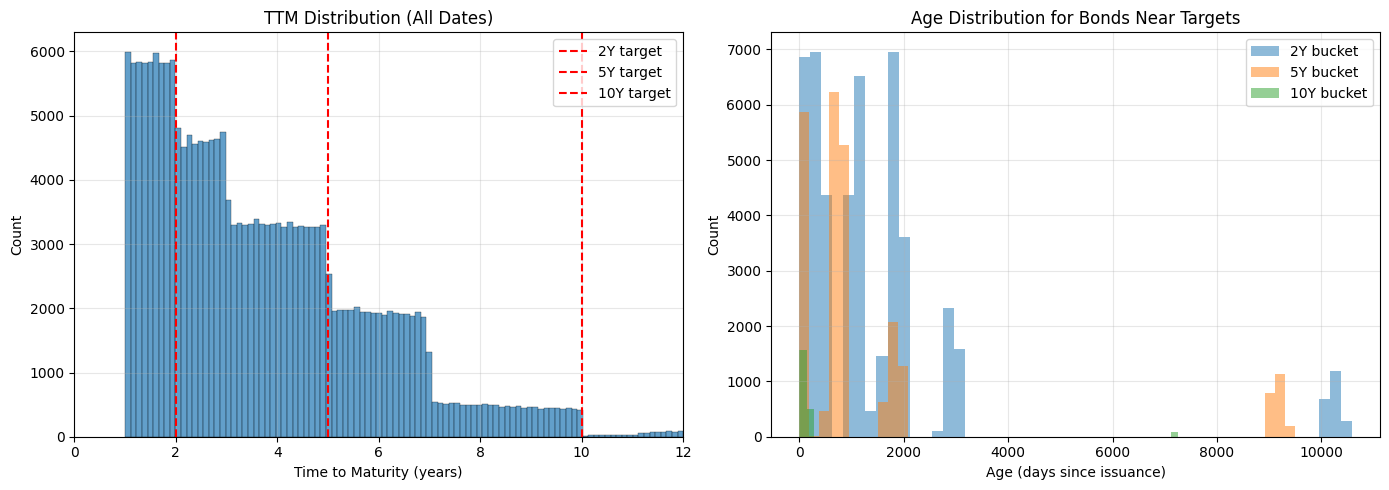

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(panel["ttm"], bins=100, alpha=0.7, edgecolor="black", linewidth=0.3)
for t in target_mats:
    axes[0].axvline(t, color="red", linestyle="--", linewidth=1.5, label=f"{t}Y target")
axes[0].set_title("TTM Distribution (All Dates)")
axes[0].set_xlabel("Time to Maturity (years)")
axes[0].set_ylabel("Count")
axes[0].legend()
axes[0].set_xlim(0, 12)
axes[0].grid(True, alpha=0.3)

for t in target_mats:
    nearby = panel[(panel["ttm"] >= t - tolerance) & (panel["ttm"] <= t + tolerance)]
    axes[1].hist(nearby["age_days"], bins=50, alpha=0.5, label=f"{t}Y bucket")
axes[1].set_title("Age Distribution for Bonds Near Targets")
axes[1].set_xlabel("Age (days since issuance)")
axes[1].set_ylabel("Count")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [35]:
panel_dates = panel["caldt"].sort_values().unique()
gsw_dates = yields_diff.index

overlap_start = max(panel_dates.min(), gsw_dates.min())
overlap_end = min(panel_dates.max(), gsw_dates.max())
print(f"Overlap period: {pd.Timestamp(overlap_start).date()} to {pd.Timestamp(overlap_end).date()}")

yields_overlap = yields.loc[overlap_start:overlap_end]
yields_diff_overlap = yields_diff.loc[overlap_start:overlap_end]
panel_overlap = panel[(panel["caldt"] >= overlap_start) & (panel["caldt"] <= overlap_end)]
print(f"GSW trading days in overlap: {len(yields_diff_overlap)}")
print(f"Panel trading days in overlap: {panel_overlap['caldt'].nunique()}")

Overlap period: 2022-01-03 to 2025-12-26
GSW trading days in overlap: 995
Panel trading days in overlap: 996


## Part (a): Roll Schedule Design

We roll quarterly (QS), selecting the bond closest to each target maturity (2Y, 5Y, 10Y) with age as tiebreaker (prefer fresher issues for liquidity). Quarterly balances the key tradeoffs:
- **Monthly** tracks target maturities tightly but incurs ~4x the transaction costs for marginal improvement
- **Semi-annual/annual** reduces turnover but lets TTM drift too much when compared to quarterly, introducing basis risk
- **Quarterly** keeps TTM within reasonable distance of target with only 4 rolls/year

**Bond selection**: `select_bond` sorts candidates first by absolute TTM distance from target, then by `age_days` ascending. Minimizing TTM distance is the primary objective, as a bond closer to the target maturity better proxies the constant-maturity GSW yield, reducing the yield mapping error analyzed in Part (d). The age tiebreaker selects the most recently issued bond among equidistant candidates: newer issues are closer to on-the-run status, meaning tighter bid-ask spreads and deeper order books. Some bonds appear in the panel with negative `age_days` (trading in when-issued form before their official settlement date). We include them since the panel provides valid prices, yields, and durations for these observations, and excluding them would discard the freshest available proxy at roll dates near new issuance.

The 10Y bucket shows the most tracking variability due to sparser issuance at that tenor. The TTM tracking plots below compare all four frequencies.

In [36]:
def select_bond(day_panel: pd.DataFrame, target_maturity: float) -> pd.Series:
    _panel = day_panel.assign(ttm_dist=(pd.col("ttm") - target_maturity).abs()).sort_values(
        ["ttm_dist", "age_days"]
    )

    return _panel.iloc[0]


def build_roll_schedule(panel: pd.DataFrame, target_maturities: list, freq: str) -> pd.DataFrame:
    dates = panel["caldt"].sort_values().unique()
    roll_dates = pd.date_range(dates.min(), dates.max(), freq=freq)
    roll_dates = [min(dates, key=lambda d: abs(d - rd)) for rd in roll_dates]
    roll_dates = sorted(set(roll_dates))

    records = []
    for rd in roll_dates:
        day = panel[panel["caldt"] == rd]
        record = {"roll_date": rd}
        for t in target_maturities:
            bond = select_bond(day, t)
            if bond is not None:
                record[f"{t}Y_id"] = bond["kytreasno"]
                record[f"{t}Y_ttm"] = bond["ttm"]
                record[f"{t}Y_duration"] = bond["duration"]
                record[f"{t}Y_age"] = bond["age_days"]
                record[f"{t}Y_cusip"] = bond["cusip"]
        records.append(record)

    return pd.DataFrame(records)

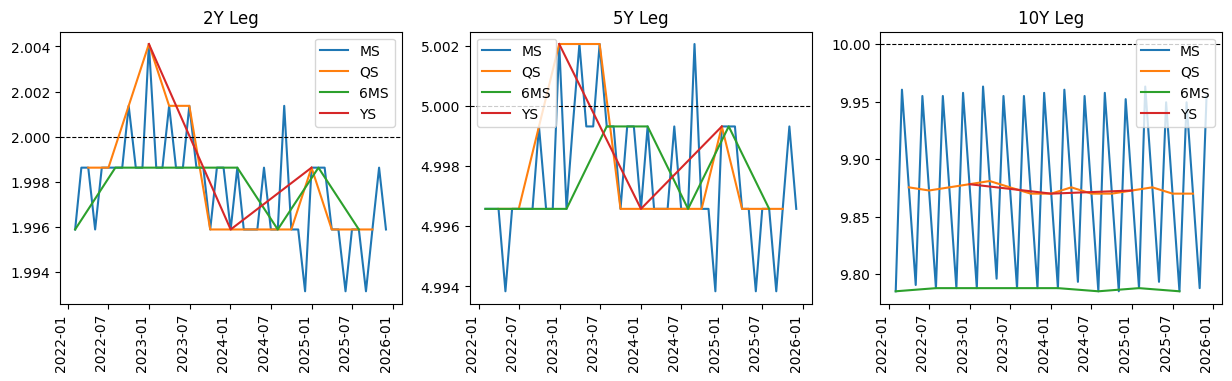

In [37]:
roll_schedules = ("MS", "QS", "6MS", "YS")
scheds = tuple(build_roll_schedule(panel, [2, 5, 10], freq=f) for f in roll_schedules)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for i, t in enumerate([2, 5, 10]):
    for roll, sched in zip(roll_schedules, scheds):
        axes[i].plot(sched["roll_date"], sched[f"{t}Y_ttm"], label=roll)

    axes[i].axhline(t, color="k", ls="--", lw=0.8)
    axes[i].set_title(f"{t}Y Leg")
    axes[i].legend()
fig.autofmt_xdate(rotation=90)

## Part (b): Bond-Space Butterfly Returns

The butterfly portfolio applies PCA-neutral weights scaled by duration (h = w/D) to actual bond dirty-price returns. Individual legs display duration-scaled volatility: the 10Y leg dominates, the 2Y is comparatively stable. The weighted portfolio return is an order of magnitude smaller than any single leg, as the PCA weighting removes most level and slope exposure.

In [38]:
ROLL_FREQ = "QS"
sched = build_roll_schedule(panel_overlap, [2, 5, 10], freq=ROLL_FREQ)

In [39]:
def compute_bond_returns(
    panel: pd.DataFrame, sched: pd.DataFrame, weights: np.ndarray
) -> pd.DataFrame:
    all_periods = []

    for i in range(len(sched) - 1):
        row = sched.iloc[i]
        next_roll = sched.iloc[i + 1]["roll_date"]

        bond_ids = [int(row[f"{t}Y_id"]) for t in target_mats]
        durations = np.array([row[f"{t}Y_duration"] for t in target_mats])
        h = weights / durations

        mask = (
            (panel["caldt"] >= row["roll_date"])
            & (panel["caldt"] <= next_roll)
            & panel["kytreasno"].isin(bond_ids)
        )
        period = panel[mask]

        def pivot_field(field):
            piv = period.pivot(index="caldt", columns="kytreasno", values=field)[bond_ids]
            piv.columns = [f"{t}_{field}" for t in target_mats]
            return piv

        df = pd.concat([pivot_field(f) for f in ("dirty_price", "ytm", "duration")], axis=1)

        for t in target_mats:
            df[f"{t}_ret"] = df[f"{t}_dirty_price"].pct_change()
            df[f"{t}_dytm"] = df[f"{t}_ytm"].diff()

        df = df.iloc[1:]
        df["port_return"] = df[[f"{t}_ret" for t in target_mats]].values @ h

        all_periods.append(df)

    return pd.concat(all_periods)

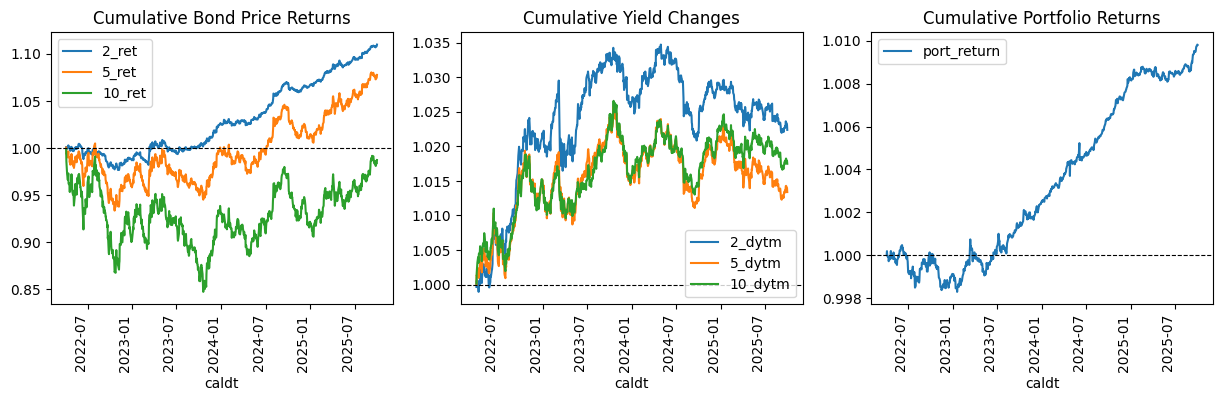

In [40]:
bond_returns = compute_bond_returns(panel_overlap, sched, weights)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
bond_returns[[f"{t}_ret" for t in target_mats]].add(1).cumprod().plot(ax=axes[0])
bond_returns[[f"{t}_dytm" for t in target_mats]].cumsum().add(1).plot(ax=axes[1])
bond_returns[["port_return"]].add(1).cumprod().plot(ax=axes[2])


for i in range(3):
    axes[i].axhline(1.0, color="k", ls="--", lw=0.8)
    axes[i].legend()

axes[0].set_title("Cumulative Bond Price Returns")
axes[1].set_title("Cumulative Yield Changes")
axes[2].set_title("Cumulative Portfolio Returns")


fig.autofmt_xdate(rotation=90)

## Part (c): Yield-Space vs Bond-Space Comparison

Daily correlation = 0.43, R² = 0.18. The yield-space backtest explains less than a fifth of bond-space return variance. The OLS slope of 0.33 means yield-space changes overstate bond-space magnitudes by ~3x. Rolling 60-day correlation is highly unstable (ranging from negative to near 1), and cumulative P&L paths diverge substantially. The yield-space backtest is a poor predictor of realized bond-space P&L.

In [41]:
yield_butterfly = yields_diff_overlap @ weights
yield_butterfly.name = "yield_butterfly"

all_returns = bond_returns.join(yield_butterfly).dropna()

In [42]:
YIELD_SCALE = 100

all_returns["yield_scaled"] = -all_returns["yield_butterfly"] / YIELD_SCALE

corr = all_returns["port_return"].corr(all_returns["yield_scaled"])
r2 = corr**2
slope, intercept = np.polyfit(all_returns["yield_scaled"], all_returns["port_return"], 1)

print(f"""Correlation:       {corr:.4f}
R-squared:         {r2:.4f}
Regression slope:  {slope:.4f}
Regression intcpt: {intercept:.6f}
N observations:    {len(all_returns)}""")

Correlation:       0.4271
R-squared:         0.1824
Regression slope:  0.3290
Regression intcpt: 0.000013
N observations:    874


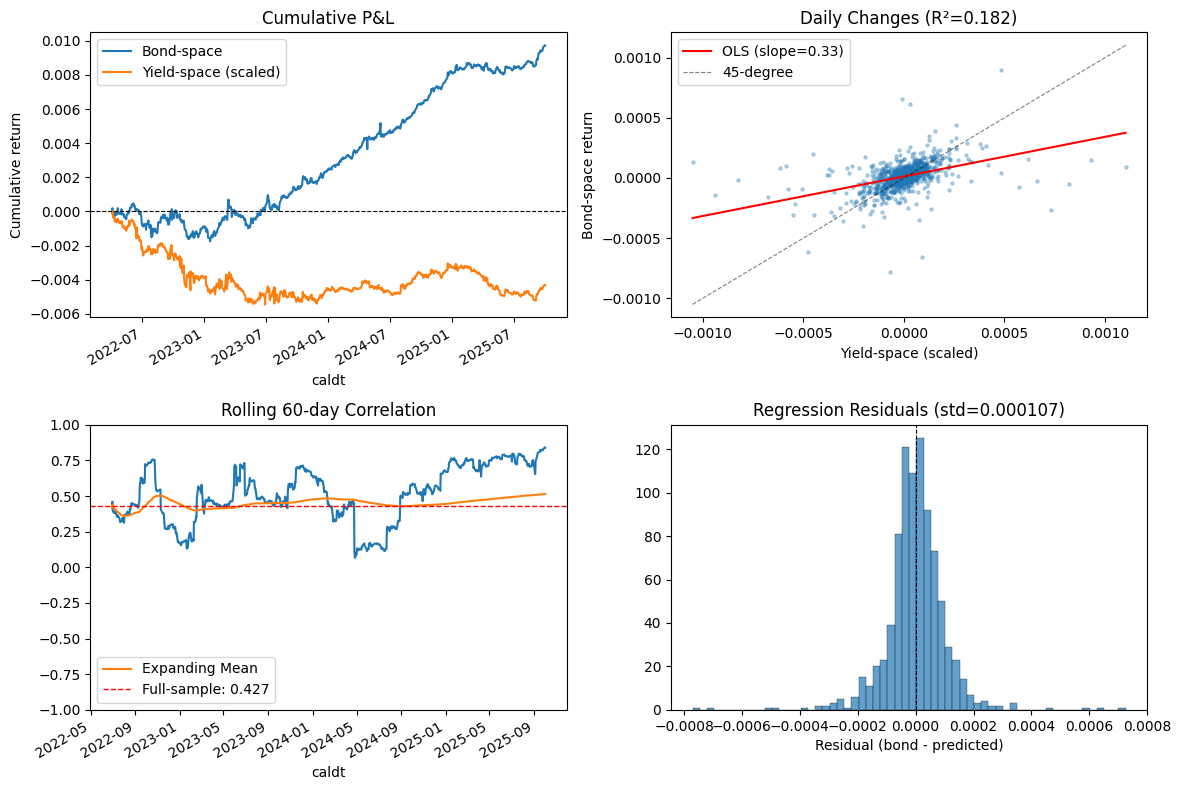

In [43]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

all_returns["port_return"].cumsum().plot(ax=axes[0, 0], label="Bond-space")
all_returns["yield_scaled"].cumsum().plot(ax=axes[0, 0], label="Yield-space (scaled)")
axes[0, 0].set_title("Cumulative P&L")
axes[0, 0].axhline(0, color="k", ls="--", lw=0.8)
axes[0, 0].legend()
axes[0, 0].set_ylabel("Cumulative return")

axes[0, 1].scatter(all_returns["yield_scaled"], all_returns["port_return"], alpha=0.3, s=5)
lims = [all_returns["yield_scaled"].min(), all_returns["yield_scaled"].max()]
axes[0, 1].plot(
    lims, np.polyval([slope, intercept], lims), "r-", lw=1.5, label=f"OLS (slope={slope:.2f})"
)
axes[0, 1].plot(lims, lims, "k--", lw=0.8, alpha=0.5, label="45-degree")
axes[0, 1].set_xlabel("Yield-space (scaled)")
axes[0, 1].set_ylabel("Bond-space return")
axes[0, 1].set_title(f"Daily Changes (R²={r2:.3f})")
axes[0, 1].legend()

rolling_corr = all_returns["port_return"].rolling(60).corr(all_returns["yield_scaled"])
rolling_corr.plot(ax=axes[1, 0])
rolling_corr.expanding().mean().plot(ax=axes[1, 0], label="Expanding Mean")
axes[1, 0].axhline(corr, color="r", ls="--", lw=1, label=f"Full-sample: {corr:.3f}")
axes[1, 0].set_title("Rolling 60-day Correlation")
axes[1, 0].set_ylim(-1, 1)
axes[1, 0].legend()

residuals = all_returns["port_return"] - (slope * all_returns["yield_scaled"] + intercept)
axes[1, 1].hist(residuals, bins=60, edgecolor="black", linewidth=0.3, alpha=0.7)
axes[1, 1].axvline(0, color="k", ls="--", lw=0.8)
axes[1, 1].set_title(f"Regression Residuals (std={residuals.std():.6f})")
axes[1, 1].set_xlabel("Residual (bond - predicted)")

plt.tight_layout()
plt.show()

## Part (d): Sources of Discrepancy

### d.i — Yield Mapping: GSW vs Held Bond Yield Changes

Three factors cause held-bond yield changes to differ from GSW constant-maturity yields:
- TTM mismatch: the bond ages between rolls while GSW interpolates at fixed maturity
- GSW is a fitted smooth curve while individual bonds price with idiosyncratic spreads
- On-the-run/off-the-run effects: per-leg correlations are high, but the butterfly weighting amplifies small residuals, degrading portfolio-level yield correspondence.

In [44]:
gsw_dy = yields_diff_overlap / YIELD_SCALE
gsw_dy.columns = [f"{t}_gsw_dy" for t in target_mats]

yield_compare = bond_returns[[f"{t}_dytm" for t in target_mats]].join(gsw_dy, how="inner")

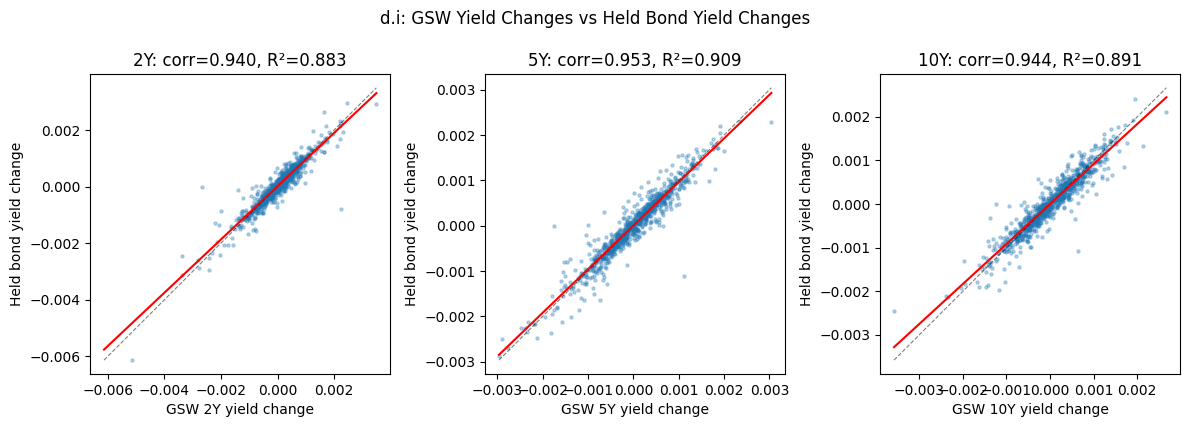

In [45]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
labels = {2: "2Y", 5: "5Y", 10: "10Y"}

for i, t in enumerate(target_mats):
    x = yield_compare[f"{t}_gsw_dy"]
    y = yield_compare[f"{t}_dytm"]
    r = x.corr(y)

    axes[i].scatter(x, y, alpha=0.3, s=5)
    lims = [min(x.min(), y.min()), max(x.max(), y.max())]
    axes[i].plot(lims, lims, "k--", lw=0.8, alpha=0.5)
    slope_i, int_i = np.polyfit(x, y, 1)
    axes[i].plot(lims, np.polyval([slope_i, int_i], lims), "r-", lw=1.5)
    axes[i].set_xlabel(f"GSW {labels[t]} yield change")
    axes[i].set_ylabel("Held bond yield change")
    axes[i].set_title(f"{labels[t]}: corr={r:.3f}, R²={r**2:.3f}")
    axes[i].set_aspect("equal")

plt.suptitle("d.i: GSW Yield Changes vs Held Bond Yield Changes", y=1.02)
plt.tight_layout()
plt.show()

In [50]:
print("Per-leg yield mapping: GSW vs held bond yield changes")
for t in target_mats:
    x, y = yield_compare[f"{t}_gsw_dy"], yield_compare[f"{t}_dytm"]
    r = x.corr(y)
    print(f"  {labels[t]}: corr={r:.4f}, R²={r**2:.4f}")

bond_dy_w = yield_compare[[f"{t}_dytm" for t in target_mats]].values @ weights
gsw_dy_w = yield_compare[[f"{t}_gsw_dy" for t in target_mats]].values @ weights
r_port = np.corrcoef(bond_dy_w, gsw_dy_w)[0, 1]
print(f"\n  Portfolio (butterfly-weighted): corr={r_port:.4f}, R²={r_port**2:.4f}")

Per-leg yield mapping: GSW vs held bond yield changes
  2Y: corr=0.9397, R²=0.8831
  5Y: corr=0.9535, R²=0.9091
  10Y: corr=0.9439, R²=0.8910

  Portfolio (butterfly-weighted): corr=0.4249, R²=0.1806


### d.ii — Duration Approximation: First-Order vs Actual Returns

The duration approximation (ret = -D * dy) fits individual bond returns very well at daily frequency — convexity terms are negligible for typical daily yield moves of a few basis points. The systematic positive residual (actual minus approximated) reflects daily coupon accrual (carry) that the yield-based approximation ignores. While small per day, this carry residual accumulates over time and is the dominant driver of cumulative P&L drift.

In [51]:
dur_compare = pd.DataFrame(index=bond_returns.index)
for t in target_mats:
    dur_compare[f"{t}_ret"] = bond_returns[f"{t}_ret"]
    dur_compare[f"{t}_ret_approx"] = (
        -bond_returns[f"{t}_duration"].shift(1) * bond_returns[f"{t}_dytm"]
    )

dur_compare = dur_compare.dropna()

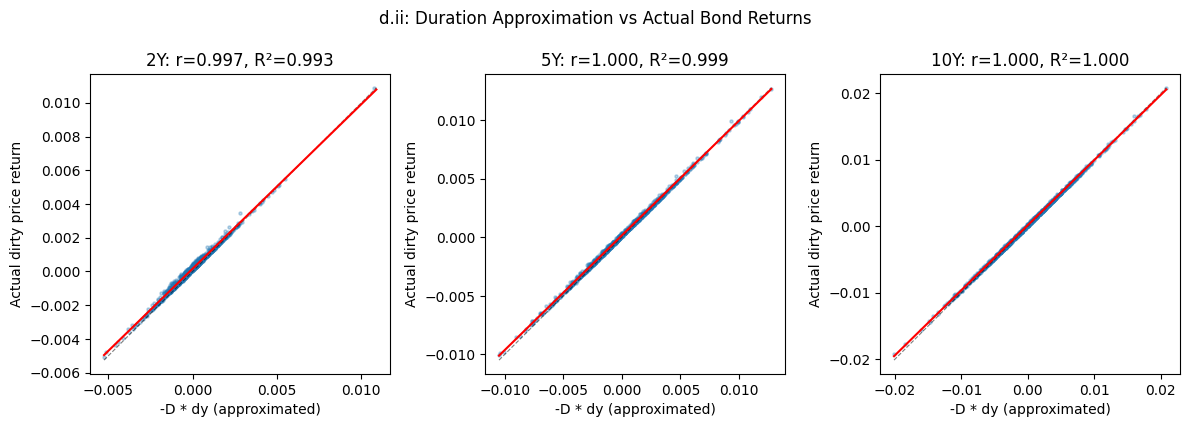

In [48]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, t in enumerate(target_mats):
    x = dur_compare[f"{t}_ret_approx"]
    y = dur_compare[f"{t}_ret"]
    r = x.corr(y)

    axes[i].scatter(x, y, alpha=0.3, s=5)
    lims = [min(x.min(), y.min()), max(x.max(), y.max())]
    axes[i].plot(lims, lims, "k--", lw=0.8, alpha=0.5)
    slope_i, int_i = np.polyfit(x, y, 1)
    axes[i].plot(lims, np.polyval([slope_i, int_i], lims), "r-", lw=1.5)
    axes[i].set_xlabel("-D * dy (approximated)")
    axes[i].set_ylabel("Actual dirty price return")
    axes[i].set_title(f"{labels[t]}: r={r:.3f}, R²={r**2:.3f}")
    axes[i].set_aspect("equal")

plt.suptitle("d.ii: Duration Approximation vs Actual Bond Returns", y=1.02)
plt.tight_layout()
plt.show()

Per-leg duration approximation fit:
  2Y: R²=0.9932, mean carry residual=1.681 bps/day
  5Y: R²=0.9990, mean carry residual=1.634 bps/day
  10Y: R²=0.9996, mean carry residual=1.768 bps/day
  (Positive residual = daily coupon accrual not captured by -D*dy)

Cumulative gap decomposition (874 days):
  Total gap:          0.014042
  Yield mapping:     -0.003263
  Carry + convexity:  0.017305


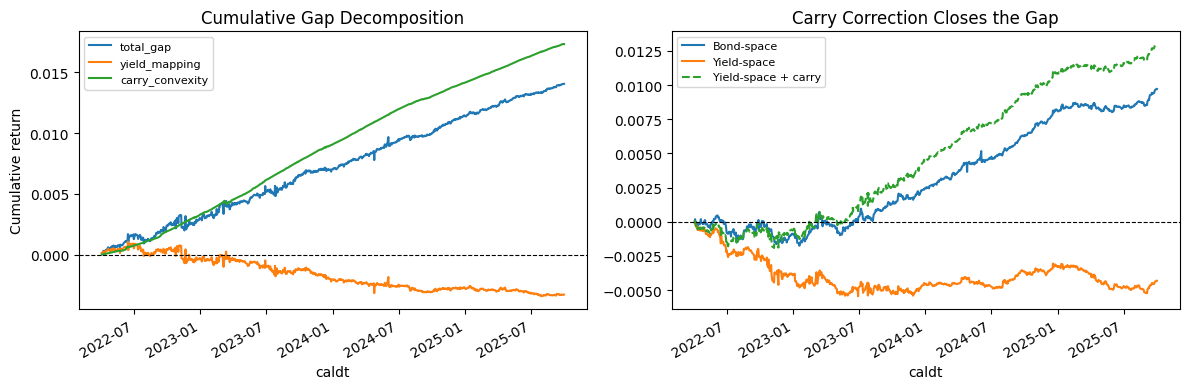

In [ ]:
print("Per-leg duration approximation fit:")
for t in target_mats:
    x, y = dur_compare[f"{t}_ret_approx"], dur_compare[f"{t}_ret"]
    r = x.corr(y)
    carry = (y - x).mean()
    print(f"  {labels[t]}: R²={r**2:.4f}, mean carry residual={carry * 1e4:.3f} bps/day")
print("  (Positive residual = daily coupon accrual not captured by -D*dy)")

# Decompose total P&L gap: yield mapping + carry/convexity
# gap = port_return - yield_scaled
#     = -w.(dy_bond - dy_GSW) + (port_return + w.dy_bond)
#     = yield_mapping       + carry_convexity
bond_dytm = all_returns[[f"{t}_dytm" for t in target_mats]].values
gsw_dytm = gsw_dy.reindex(all_returns.index).values

decomp = pd.DataFrame(index=all_returns.index)
decomp["total_gap"] = all_returns["port_return"] - all_returns["yield_scaled"]
decomp["yield_mapping"] = -(bond_dytm - gsw_dytm) @ weights
decomp["carry_convexity"] = all_returns["port_return"] + bond_dytm @ weights
decomp = decomp.dropna()

print(f"\nCumulative gap decomposition ({len(decomp)} days):")
print(f"  Total gap:         {decomp['total_gap'].sum(): .6f}")
print(f"  Yield mapping:     {decomp['yield_mapping'].sum(): .6f}")
print(f"  Carry + convexity: {decomp['carry_convexity'].sum(): .6f}")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
decomp[["total_gap", "yield_mapping", "carry_convexity"]].cumsum().plot(ax=axes[0])
axes[0].set_title("Cumulative Gap Decomposition")
axes[0].set_ylabel("Cumulative return")
axes[0].axhline(0, color="k", ls="--", lw=0.8)
axes[0].legend(fontsize=8)

all_returns["port_return"].cumsum().plot(ax=axes[1], label="Bond-space")
all_returns["yield_scaled"].cumsum().plot(ax=axes[1], label="Yield-space")
(
    all_returns["yield_scaled"] + decomp.reindex(all_returns.index)["carry_convexity"].fillna(0)
).cumsum().plot(ax=axes[1], label="Yield-space + carry", ls="--")
axes[1].set_title("Carry Correction Closes the Gap")
axes[1].axhline(0, color="k", ls="--", lw=0.8)
axes[1].legend(fontsize=8)

plt.tight_layout()
plt.show()

## Part (e): Discussion

### Is the yield-space backtest reliable?

Not really, R² = 0.18 means ~80% of bond-space return variance is unexplained. The gap decomposes into three layers:

**Yield mapping** (moderate): Per-leg correlations between GSW and held-bond yield changes are very high, but the butterfly weighting amplifies small residuals, degrading portfolio-level correspondence.

**Duration approximation** (negligible): R² > 0.99 per leg at daily frequency. Not a meaningful error source.

**Carry** (dominant): The primary driver of cumulative divergence. Each day, bonds accrue coupon interest regardless of yield movements. The butterfly's net carry (long wing coupons minus short body coupon, scaled by hedge ratios) is persistent and nonzero.

### Why daily returns correlate but cumulative P&L diverges

Daily bond returns are dominated by price changes from yield movements (~5-15 bps/day moves), which dwarf the ~1 bp/day carry accrual. So on any given day, yield-space and bond-space returns move together and daily correlation is reasonable.

But carry has near-zero variance: it is the same sign and similar magnitude every day. Over N days, the yield-driven component grows as sqrt(N) (random walk) while carry grows as N (linear accumulation). Eventually carry dominates cumulative P&L. The yield-space backtest captures the volatile price component but completely misses the steady carry drift. For long positions, coupon accrual steadily increases dirty-price returns beyond what yields alone predict; for short positions, the coupon owed steadily drags returns. In the butterfly, the net effect depends on the coupon rates of the wing vs body bonds and the hedge ratios, but it is almost never zero.

The decomposition plots above confirm this: the carry+convexity component accounts for most of the cumulative gap, while the yield mapping component oscillates without a strong trend.

### Production adjustments

- Model carry explicitly (daily coupon accrual per position)
- Track actual CUSIPs with financing (repo) costs
- Account for bid-ask spreads at each roll
- Use threshold-based rolling rather than fixed calendar dates
- Include market impact for realistic position sizes